Notes: ['A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#']
sample_rate =  44100


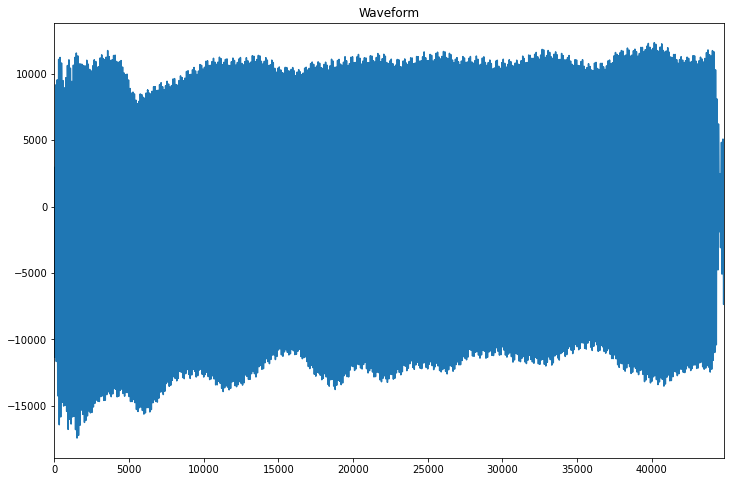

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io.wavfile
from scipy.fftpack import dct
 
data_dir = pathlib.Path(r"D:\magistracy\diplom\records_cut")
filenames = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if(file.endswith(".wav")):
            filenames.append(os.path.join(root,file))    

notes = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Notes:', notes)

#test_file = tf.io.read_file(filenames[0])
#test_audio, _ = tf.audio.decode_wav(contents=test_file)
#signal = test_audio
sample_rate, signal = scipy.io.wavfile.read(filenames[0])
print('sample_rate = ', sample_rate)

fig, ax = plt.subplots(1, figsize=(12, 8))
timescale = np.arange(signal.shape[0])
ax.plot(timescale, signal)
ax.set_title('Waveform')
ax.set_xlim([0, signal.shape[0]])
plt.show()

## Предварительное искажение для усиления высоких частот
Такая предварительная обработка полезна для:  
- Сбалансировки частотного спектра, т.к. высокие частоты обычно имеют меньшую амплитуду по сравнению с более низкими частотами;
- Избежания числовых проблем во время операции преобразования Фурье;
- Улучшения отношения сигнал-шум (SNR).

Формула фильтра предыскажения: $$y(t) = x(t)-\alpha x(t-1),\quad\quad\quad (1)$$
где $\alpha = 0.95$ или $\alpha = 0.97$. Рассмотрим $\alpha = 0.97$.  

Предыскажение имеет скромный эффект в современных системах, главным образом потому, что большинство мотивов для фильтра предыскажения может быть достигнуто с помощью нормализации среднего, за исключением избежания числовых проблем преобразования Фурье, которые не должны быть проблемой в современных реализациях БПФ.

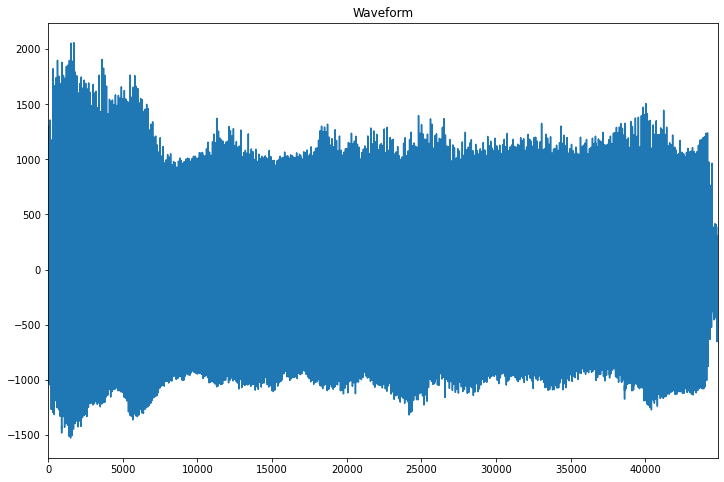

In [2]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

fig, ax = plt.subplots(1, figsize=(12, 8))
timescale = np.arange(emphasized_signal.shape[0])
ax.plot(timescale, emphasized_signal)
ax.set_title('Waveform')
ax.set_xlim([0, emphasized_signal.shape[0]])
plt.show()

## Выделение фреймов
После предыскажения нам нужно разбить сигнал на короткие временные рамки. Обоснование этого шага заключается в том, что частоты сигнала меняются со временем, поэтому в большинстве случаев нет смысла выполнять преобразование Фурье для всего сигнала, поскольку со временем мы потеряли бы частотные контуры сигнала. Чтобы избежать этого, мы можем с уверенностью предположить, что частоты в сигнале остаются постоянными в течение очень короткого периода времени. Следовательно, выполняя преобразование Фурье для этого короткого кадра, мы можем получить хорошую аппроксимацию частотных контуров сигнала путем объединения соседних кадров. Типичные размеры кадров при обработке речи находятся в диапазоне от 20 мс до 40 мс с 50% (+/-10%) перекрытием между последовательными кадрами. Мы рассмотрим размер кадра, равный 2048 отсчетов (примерно 46 мс при частоте дискретизации равной 44.1 кГц), и шаг кадра, равный половине размера кадра.

In [5]:
frame_length = 2048
frame_step = frame_length/2
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # чтобы убедиться, что у нас есть хотя бы 1 кадр.
 
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # чтобы убедиться, что все кадры имеют одинаковое количество сэмплов без усечения сэмплов исходного сигнала.
 
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

## Применение оконной функции
После разделения сигнала на кадры мы применяем оконную функцию, такую как окно Хэмминга, к каждому кадру. Окно Хэмминга имеет следующий вид: $$w(n) = 0.54-0.46 \bullet \cos(2\pi nN-1),\quad\quad\quad (2)$$
где $0\leq n \leq N-1$, $N$ - длина окна.  

Есть несколько причин, по которым нам необходимо применять оконную функцию к кадрам, в частности, чтобы противодействовать предположению, сделанному БПФ, о том, что данные бесконечны, и уменьшить спектральную утечку.

In [6]:
frames *= np.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))

## Преобразование Фурье и Спектр мощности
Теперь мы можем выполнить $N$-точечное БПФ для каждого кадра, чтобы рассчитать частотный спектр, который также называется кратковременным преобразованием Фурье (STFT), где $N$ обычно равно 256 или 512 (рассмотрим $N$ = 512); а затем вычислить спектр мощности (периодограмму), используя следующее уравнение: $$P = \frac{|FFT(x_i)|^{2}}{N},\quad\quad\quad(3)$$
где $x_i$ - $i$-тый кадр сигнала $x$.

In [7]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # величина БПФ
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # спектр мощности

## Банки фильтров
Последним шагом к вычислению банков фильтров является применение треугольных фильтров, обычно 40 фильтров, по шкале Мела, к спектру мощности для выделения частотных диапазонов. Шкала Мела направлена на то, чтобы имитировать нелинейное восприятие звука человеческим ухом, будучи более различимой на более низких частотах и менее различимой на более высоких частотах. Мы можем конвертировать между Герцами (f) и Mel (m), используя следующие уравнения:
$$m = 2595 \log_{10} \left(1+\frac{f}{700}\right), \quad\quad\quad(4)$$
$$f = 700 \left(10^{\frac{m}{2595}}-1\right).\quad\quad\quad(5)$$

Каждый фильтр в банке фильтров имеет треугольную форму с откликом 1 на центральной частоте и линейно уменьшается к 0, пока не достигнет центральных частот двух соседних фильтров, где отклик равен 0. Это можно смоделировать с помощью следующего уравнения: 
$$
H_m (k)=
\begin{cases}
   0, &\text{ $k<f(m-1)$},\\
   \frac{k-f(m-1)}{f(m)-f(m-1)}, &\text{ $f(m-1) \leq k < f(m)$},\\
   \frac{f(m+1)-k}{f(m+1)-f(m)}, &\text{ $f(m) \leq k \leq f(m+1)$},\\
   0, &\text{ $k > f(m+1)$}.
 \end{cases}
\quad\quad\quad(6)
$$
$f$ - список из $M+2$ меловых частот. 

In [9]:
nfilt = 40
low_freq_mel = (2595 * np.log10(1 + (44100 / 2048) / 700))
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Конвертирование Гц в Мел
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Точки, равномерно расположенные по мел-шкале
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Конвертирование Мел в Гц

# У нас нет разрешения по частоте, необходимого для установки фильтров в точных точках, рассчитанных выше, 
# поэтому нам нужно округлить эти частоты до ближайшего бина БПФ. Этот процесс не влияет на точность признаков. 
# Чтобы преобразовать частоты в числа бинов БПФ, нам нужно знать размер БПФ и частоту дискретизации.
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

# Мы можем видеть, что окончательный банк фильтров заканчивается на бине 256, 
# что соответствует 8 кГц с размером БПФ в 512 точек.

 
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # левая сторона
    f_m = int(bin[m])             # центр
    f_m_plus = int(bin[m + 1])    # правая сторона
 
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Численная стабильность
filter_banks = 20 * np.log10(filter_banks)  # дБ
fbank1 = [f[0] for f in fbank.T]

Text(0.5, 1.0, 'The full filterbank')

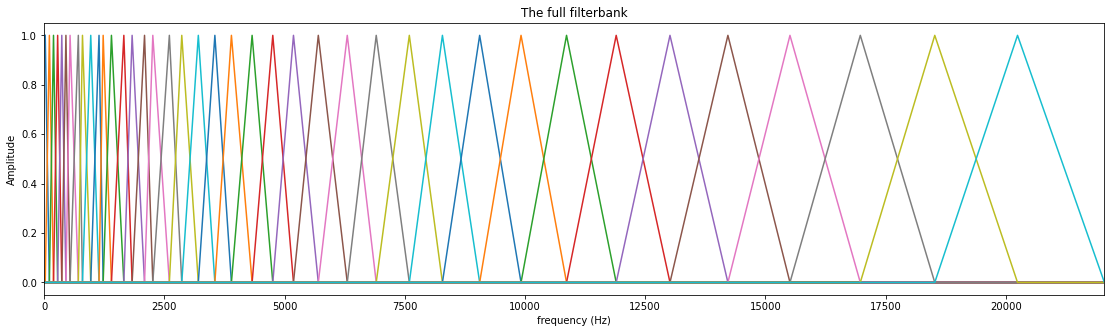

In [11]:
fig, ax = plt.subplots(1, figsize=(19, 5))
freq = np.linspace(44100/2048,sample_rate/2,int(np.floor(NFFT / 2 + 1)))
ax.plot(freq, fbank.T)
ax.set_xlim([0, sample_rate/2])
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('The full filterbank')